# Customer Churn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier

### 2. Load and Inspect the Dataset

In [2]:
# Load dataset
csv_file_path = 'data_ecommerce_customer_churn.csv'
df = pd.read_csv(csv_file_path, encoding='latin1', on_bad_lines='skip')

# Inspect the first few rows
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [3]:
# Summary Statistics
print("\nSummary Statistics:\n", df.describe())

# Check Data Types and Missing Values
print("\nDataset Information:\n", df.info())

# Check for missing values
print("\nMissing Values Before Cleaning:\n", df.isnull().sum())


Summary Statistics:
             Tenure  WarehouseToHome  NumberOfDeviceRegistered  \
count  3747.000000      3772.000000               3941.000000   
mean     10.081398        15.650583                  3.679269   
std       8.498864         8.452301                  1.013938   
min       0.000000         5.000000                  1.000000   
25%       2.000000         9.000000                  3.000000   
50%       9.000000        14.000000                  4.000000   
75%      16.000000        21.000000                  4.000000   
max      61.000000       127.000000                  6.000000   

       SatisfactionScore  NumberOfAddress     Complain  DaySinceLastOrder  \
count        3941.000000      3941.000000  3941.000000        3728.000000   
mean            3.088302         4.237757     0.282416           4.531652   
std             1.381832         2.626699     0.450232           3.667648   
min             1.000000         1.000000     0.000000           0.000000   
25%    

### 3. Handle Missing Values

In [4]:
# Handling Missing Values (Imputation)
numerical_columns = ['Tenure', 'WarehouseToHome', 'DaySinceLastOrder']
for column in numerical_columns:
    median_value = df[column].median()
    df[column].fillna(median_value, inplace=True)

# Verify no missing values remain
print("\nMissing Values After Cleaning:\n", df.isnull().sum())

# Remove Outliers using IQR Method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply outlier removal for numerical columns
numerical_columns += ['CashbackAmount', 'NumberOfDeviceRegistered', 'NumberOfAddress']
for column in numerical_columns:
    df = remove_outliers(df, column)

# Encode Categorical Features
categorical_columns = ['PreferedOrderCat', 'MaritalStatus']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)


Missing Values After Cleaning:
 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmount              0
Churn                       0
dtype: int64


C:\Users\milto\AppData\Local\Temp\ipykernel_46324\482113883.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


### 4. PreProcess Data

In [5]:
# Feature Scaling (Standardize)
scaler = StandardScaler()
features_to_scale = ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'NumberOfAddress', 
                     'DaySinceLastOrder', 'CashbackAmount', 'SatisfactionScore']
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])

# Derived Features (Create New Features)
df_encoded['AvgCashbackPerInteraction'] = df_encoded['CashbackAmount'] / (df_encoded['NumberOfDeviceRegistered'] + 1)
df_encoded['ComplaintsPerTenure'] = df_encoded['Complain'] / (df_encoded['Tenure'] + 1)
df_encoded['EngagementIntensity'] = df_encoded['NumberOfDeviceRegistered'] + df_encoded['SatisfactionScore'] + df_encoded['Complain']

In [6]:
# Feature Correlation and Removal of Highly Correlated Features
correlation_matrix = df_encoded.corr()
high_corr = [(col1, col2) for (col1, col2), val in correlation_matrix.unstack().items() if col1 != col2 and abs(val) > 0.85]
for col1, col2 in high_corr:
    if col2 in df_encoded.columns:
        df_encoded.drop(columns=[col2], inplace=True)

In [7]:
# Prepare Features and Target
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

# Class Imbalance: SMOTE and Undersampling
over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_balanced, y_balanced = pipeline.fit_resample(X, y)

# Class Distribution After Balancing
print("\nClass distribution after balancing:\n", y_balanced.value_counts())


Class distribution after balancing:
 Churn
0    1934
1    1354
Name: count, dtype: int64


C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\milto\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


#### What is the churn rate? Churn Distribution (Pie Chart/Bar Plot)

Churn Rate: 18.28%


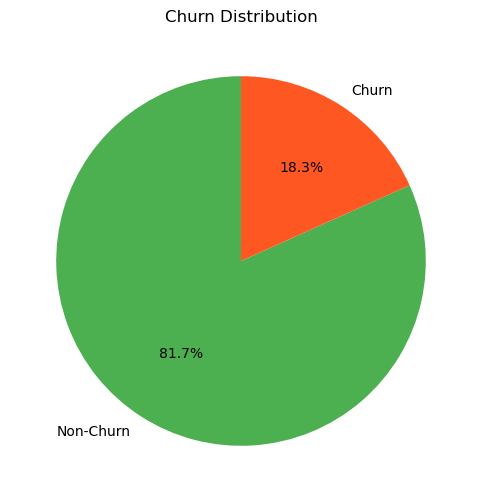

In [9]:
# Churn Rate Calculation
churn_rate = df['Churn'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

# Churn Distribution (Pie Chart)
plt.figure(figsize=(6,6))
churn_dist = df['Churn'].value_counts()
churn_dist.plot(kind='pie', autopct='%1.1f%%', startangle=90, labels=["Non-Churn", "Churn"], colors=['#4CAF50', '#FF5722'])
plt.title("Churn Distribution")
plt.ylabel("")  # Remove the y-axis label
plt.show()

#### How does customer tenure impact churn? Churn by Customer Tenure (Box Plot/Violin Plot)

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\2687928360.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Tenure', data=df, palette='Set2')


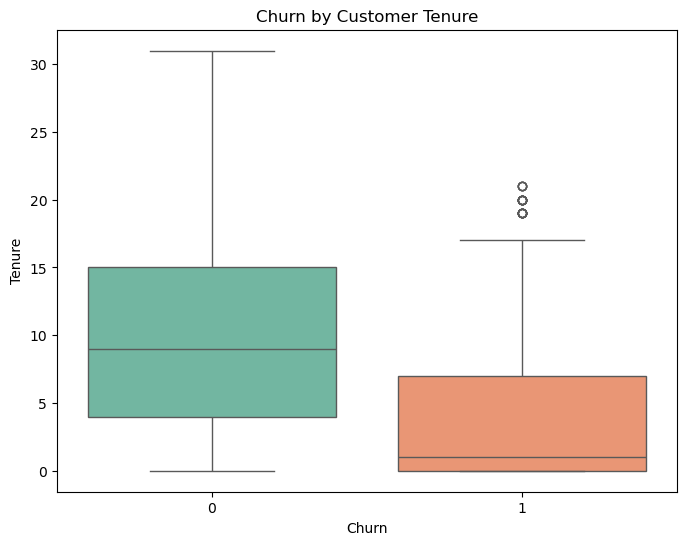

In [11]:
# Churn by Customer Tenure (Box Plot)
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='Tenure', data=df, palette='Set2')
plt.title('Churn by Customer Tenure')
plt.show()

#### How do customer satisfaction and complaints relate to churn? Churn vs. Satisfaction Score (Box Plot/Violin Plot)

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\2951610417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='SatisfactionScore', data=df, palette='Set1')


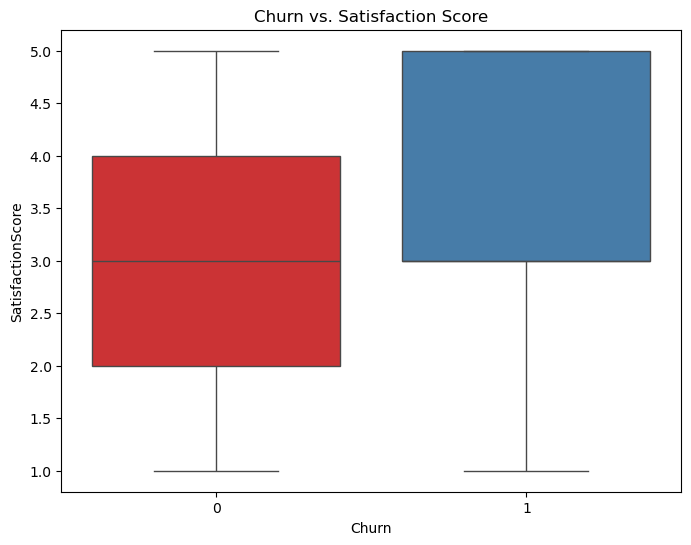

In [13]:
# Churn vs. Satisfaction Score (Box Plot)
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='SatisfactionScore', data=df, palette='Set1')
plt.title('Churn vs. Satisfaction Score')
plt.show()

#### How does the frequency of orders (e.g., "DaySinceLastOrder") affect churn?

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\1026389509.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='DaySinceLastOrder', data=df, palette='Set2')


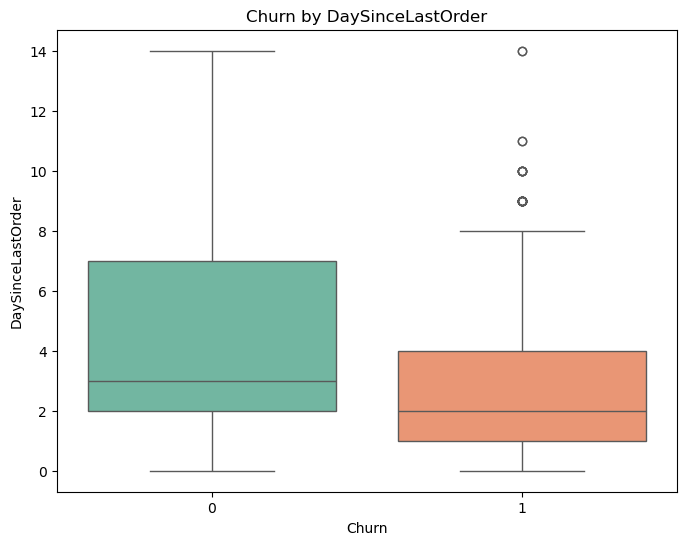

In [15]:
# Churn by DaySinceLastOrder (Box Plot)
plt.figure(figsize=(8,6))
sns.boxplot(x='Churn', y='DaySinceLastOrder', data=df, palette='Set2')
plt.title('Churn by DaySinceLastOrder')
plt.show()

#### Churn vs. Number of Complaints (Bar Plot/Violin Plot)

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\1388563195.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Churn', y='Complain', data=df, palette='Set2')


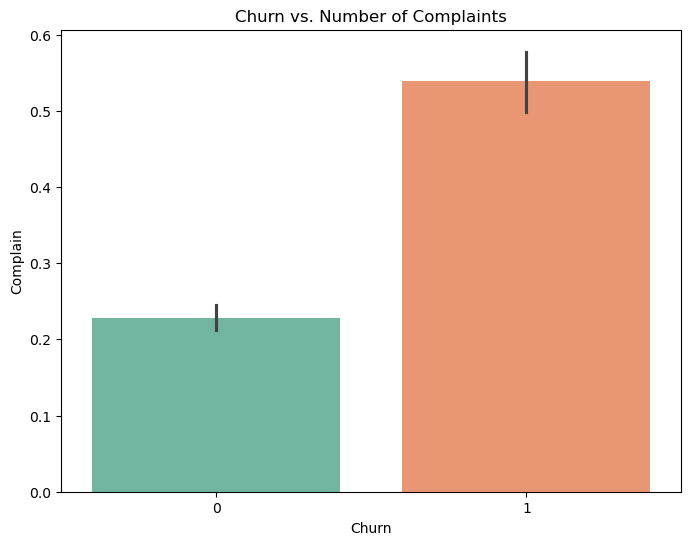

In [18]:
# Churn vs. Number of Complaints (Bar Plot)
plt.figure(figsize=(8,6))
sns.barplot(x='Churn', y='Complain', data=df, palette='Set2')
plt.title('Churn vs. Number of Complaints')
plt.show()

#### Heatmap of Correlations (Correlation Matrix)

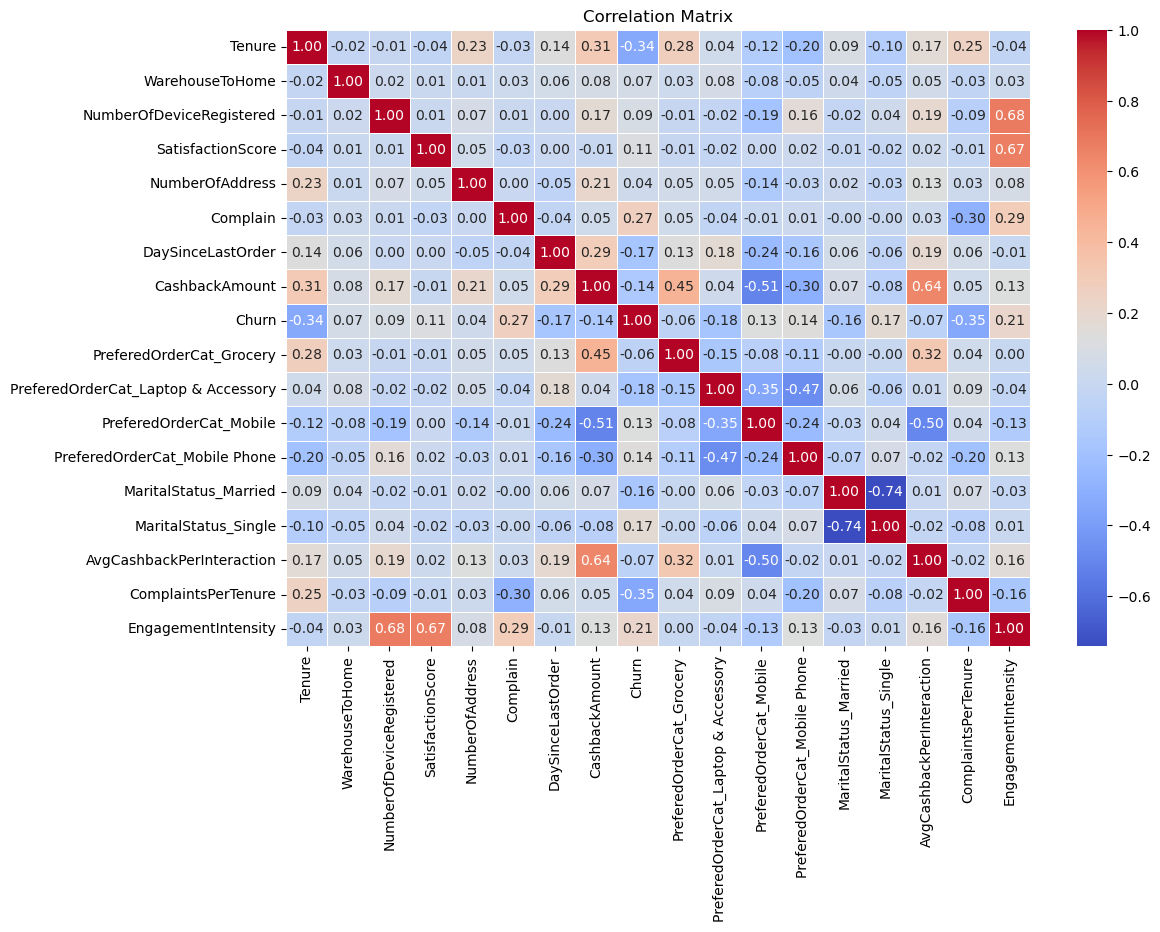

In [19]:
# Correlation Matrix (Heatmap)
corr_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Segmentation Analysis: Segment the customers based on demographic or behavior data (e.g., marital status, number of devices) and analyze churn within each segment.

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\2243843417.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MaritalStatus', y='Churn', data=df, palette='Set3')


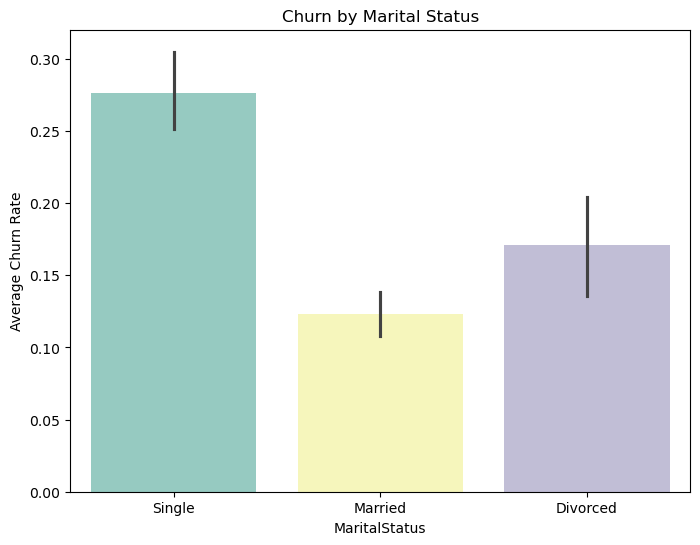

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\2243843417.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='NumberOfDeviceRegistered', y='Churn', data=df, palette='Set3')


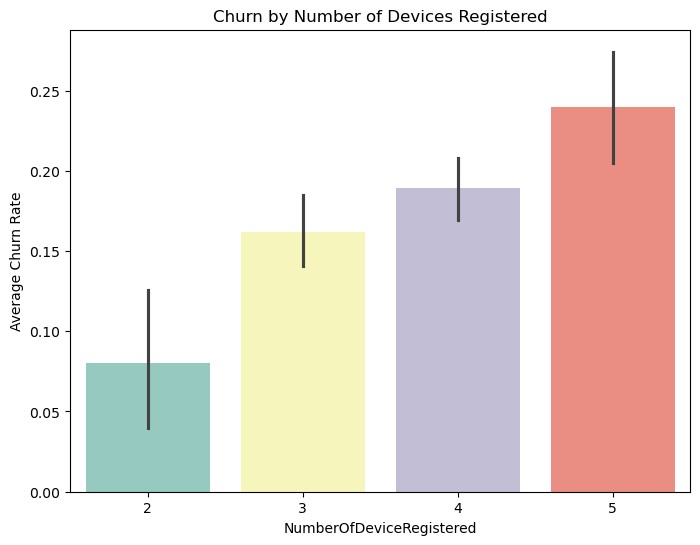

In [21]:
# Segmentation Analysis by Marital Status
plt.figure(figsize=(8,6))
sns.barplot(x='MaritalStatus', y='Churn', data=df, palette='Set3')
plt.title('Churn by Marital Status')
plt.ylabel('Average Churn Rate')
plt.show()

# Segmentation Analysis by Number of Devices
plt.figure(figsize=(8,6))
sns.barplot(x='NumberOfDeviceRegistered', y='Churn', data=df, palette='Set3')
plt.title('Churn by Number of Devices Registered')
plt.ylabel('Average Churn Rate')
plt.show()

#### Customer Journey Analysis: Track the events leading to churn (e.g., satisfaction drops, complaints, service issues).

C:\Users\milto\AppData\Local\Temp\ipykernel_46324\1954974148.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Churn', y='SatisfactionChange', data=df, palette='Set1')


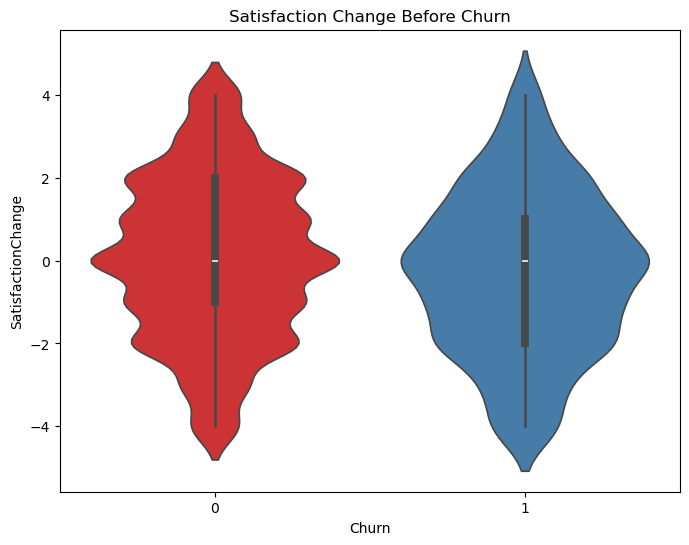

In [22]:
# Investigate satisfaction drops and complaints before churn
df['SatisfactionChange'] = df['SatisfactionScore'].diff().shift(-1)  # Satisfaction change
plt.figure(figsize=(8,6))
sns.violinplot(x='Churn', y='SatisfactionChange', data=df, palette='Set1')
plt.title('Satisfaction Change Before Churn')
plt.show()

#### Cost of Churn: Quantify the financial impact of churn and its effect on business.

### 5. Feature Importance

In [24]:
# Feature Importance using RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_balanced, y_balanced)
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", feature_importance_df)


Feature Importances:
                                 Feature  Importance
0                                Tenure    0.230901
15                  ComplaintsPerTenure    0.120809
7                        CashbackAmount    0.099263
14            AvgCashbackPerInteraction    0.084521
16                  EngagementIntensity    0.073175
6                     DaySinceLastOrder    0.069549
1                       WarehouseToHome    0.062828
4                       NumberOfAddress    0.060370
3                     SatisfactionScore    0.049439
13                 MaritalStatus_Single    0.037846
5                              Complain    0.035824
2              NumberOfDeviceRegistered    0.019539
9   PreferedOrderCat_Laptop & Accessory    0.017141
11        PreferedOrderCat_Mobile Phone    0.014024
12                MaritalStatus_Married    0.013149
10              PreferedOrderCat_Mobile    0.009170
8              PreferedOrderCat_Grocery    0.002451


### 6. Train and Evaluate the Model

In [25]:
# Train Logistic Regression with Balanced Weights
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
log_reg_balanced = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)

# Evaluate Logistic Regression Model
y_pred_balanced = log_reg_balanced.predict(X_test)
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_balanced))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_balanced))


Logistic Regression Confusion Matrix:
 [[336  70]
 [ 46 206]]

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.85       406
           1       0.75      0.82      0.78       252

    accuracy                           0.82       658
   macro avg       0.81      0.82      0.82       658
weighted avg       0.83      0.82      0.83       658



In [26]:
# Adjust decision threshold to 0.4 and evaluate again
y_probs = log_reg_balanced.predict_proba(X_test)[:, 1]
new_threshold = 0.4
y_pred_threshold = (y_probs >= new_threshold).astype(int)
print("\nConfusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_test, y_pred_threshold))
print("\nClassification Report with Adjusted Threshold:\n", classification_report(y_test, y_pred_threshold))


Confusion Matrix with Adjusted Threshold:
 [[306 100]
 [ 36 216]]

Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       0.89      0.75      0.82       406
           1       0.68      0.86      0.76       252

    accuracy                           0.79       658
   macro avg       0.79      0.81      0.79       658
weighted avg       0.81      0.79      0.80       658



In [27]:
# Adjust Decision Threshold for Logistic Regression
y_probs = log_reg_balanced.predict_proba(X_test)[:, 1]
new_threshold = 0.4
y_pred_threshold = (y_probs >= new_threshold).astype(int)
print("\nConfusion Matrix with Adjusted Threshold:\n", confusion_matrix(y_test, y_pred_threshold))
print("\nClassification Report with Adjusted Threshold:\n", classification_report(y_test, y_pred_threshold))


Confusion Matrix with Adjusted Threshold:
 [[306 100]
 [ 36 216]]

Classification Report with Adjusted Threshold:
               precision    recall  f1-score   support

           0       0.89      0.75      0.82       406
           1       0.68      0.86      0.76       252

    accuracy                           0.79       658
   macro avg       0.79      0.81      0.79       658
weighted avg       0.81      0.79      0.80       658



In [28]:
# Train XGBoost Classifier with Class Imbalance Handling
xgb_clf = XGBClassifier(objective='binary:logistic', scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), random_state=42)
xgb_clf.fit(X_train, y_train)

# Evaluate XGBoost Classifier
y_pred_xgb = xgb_clf.predict(X_test)
print("\nXGBoost Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nXGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))


XGBoost Confusion Matrix:
 [[379  27]
 [ 12 240]]

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       406
           1       0.90      0.95      0.92       252

    accuracy                           0.94       658
   macro avg       0.93      0.94      0.94       658
weighted avg       0.94      0.94      0.94       658



#### Churn Prediction with ROC Curve (Model Evaluation)

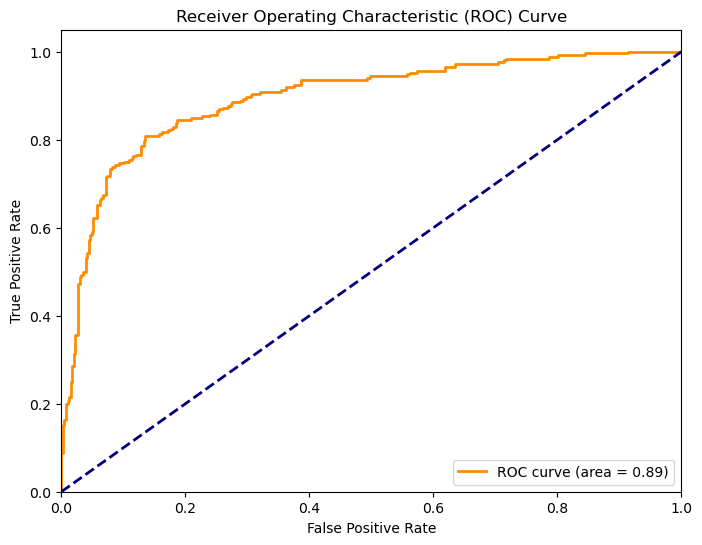

In [33]:
from sklearn.metrics import roc_curve, auc

# Train XGBoost Classifier with Class Imbalance Handling
xgb_clf = XGBClassifier(
    objective='binary:logistic',  # Binary classification
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### 7. SHAP Analysis

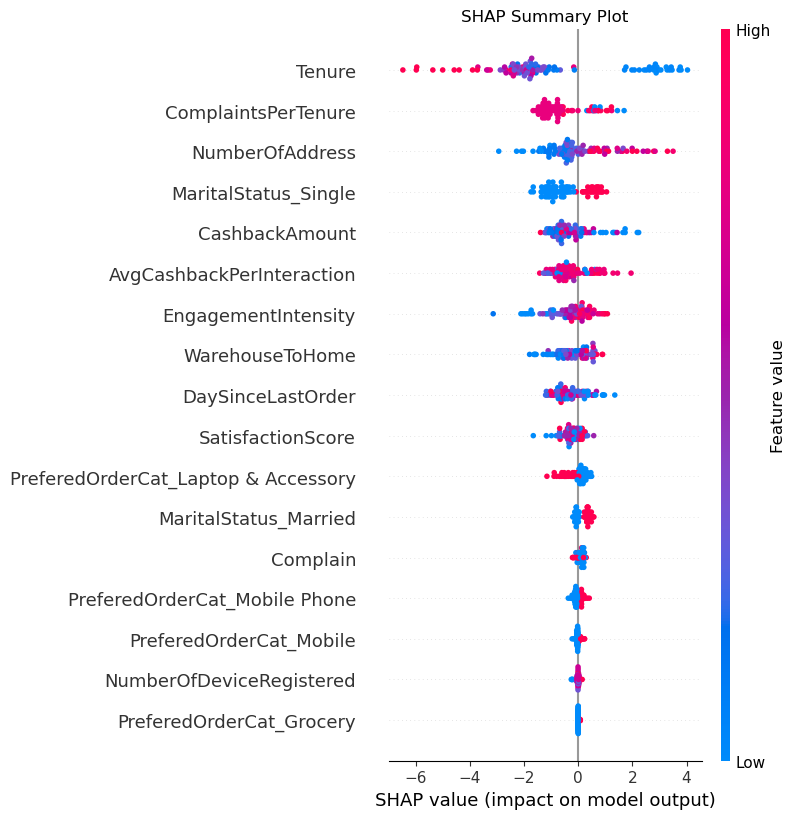

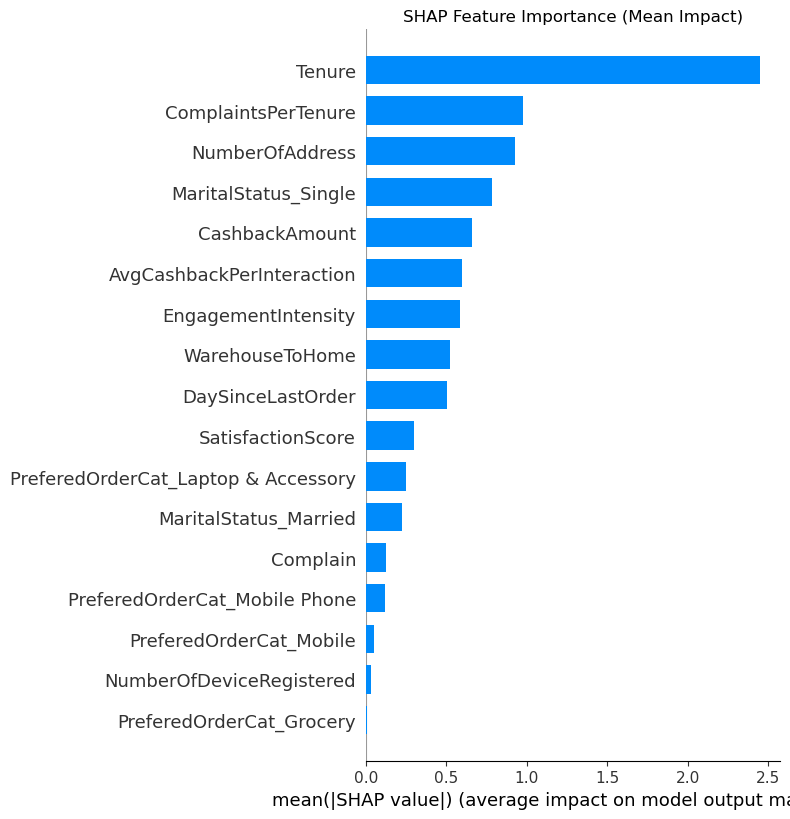

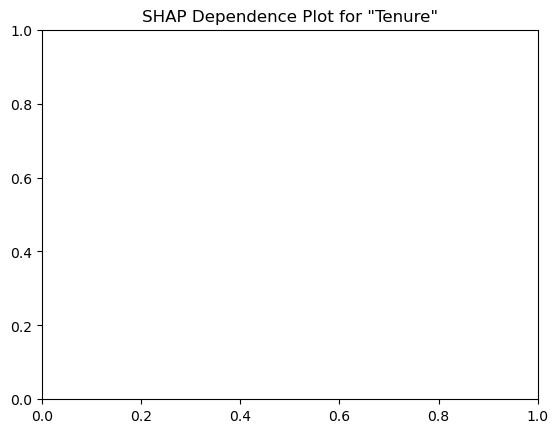

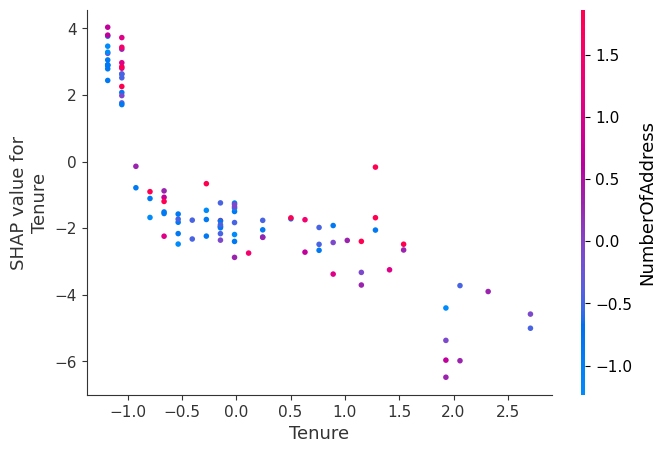

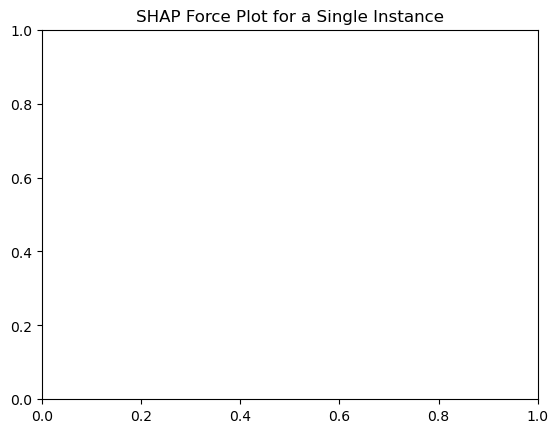

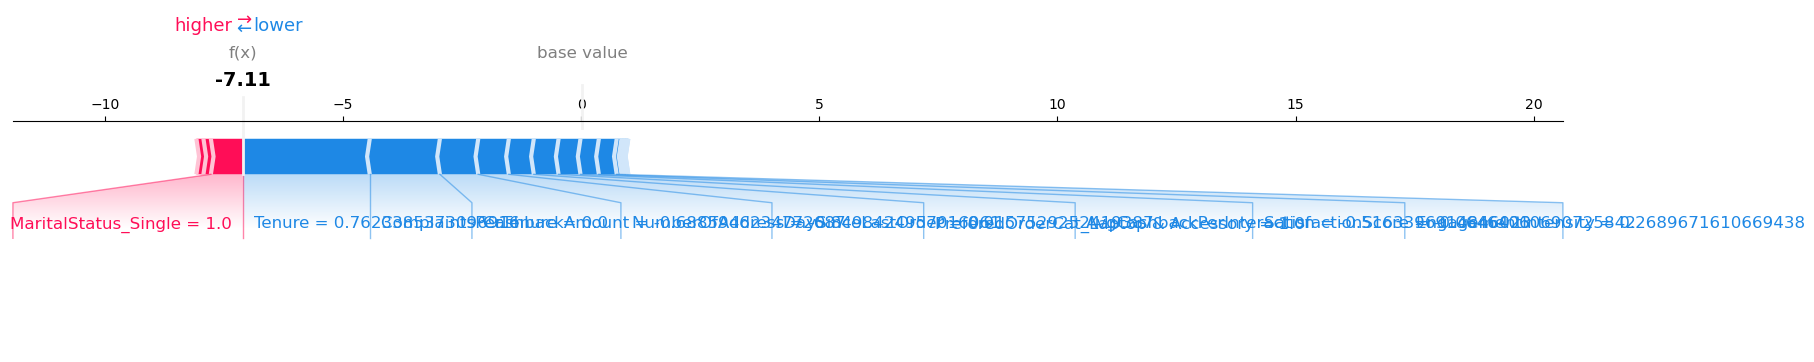

In [29]:
# SHAP Analysis for XGBoost Model
expected_features = xgb_clf.get_booster().feature_names
X_final = df_encoded[expected_features].apply(pd.to_numeric, errors='coerce').fillna(0)
X_subset = X_final.head(100)  # First 100 rows for SHAP analysis

# SHAP Explainer
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_subset)

# SHAP Summary Plot
plt.title('SHAP Summary Plot')
shap.summary_plot(shap_values, X_subset)

# SHAP Bar Plot for Feature Importance
plt.title('SHAP Feature Importance (Mean Impact)')
shap.summary_plot(shap_values, X_subset, plot_type="bar")

# SHAP Dependence Plot for 'Tenure'
plt.title('SHAP Dependence Plot for "Tenure"')
shap.dependence_plot('Tenure', shap_values, X_subset)

# SHAP Force Plot for a Single Instance
shap.initjs()
row_to_explain = 0
plt.title('SHAP Force Plot for a Single Instance')
shap.force_plot(explainer.expected_value, shap_values[row_to_explain], X_subset.iloc[row_to_explain], matplotlib=True)